## My First Kaggle Entry and My First Python ML Script!

### Preprocessing data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('D:/Grad Study!/Competition/Titanic/train.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


By looking at the schema, there are a few things I need to do before proceeding to ML algorithm:
- Drop unnecessary columns: `PassengerId`,`Name`,`Ticket`,`Cabin`,`Fare`
- Impute missing values for `Age` and `Embarked`
- Convert categorical variables: `Sex`, `Pclass`, `Embarked`

In [4]:
cols = ['Name','Ticket','Cabin','Fare']
df_train = df_train.drop(cols,axis=1)

In [5]:
df_train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,1,0,3,male,22.0,1,0,S
1,2,1,1,female,38.0,1,0,C
2,3,1,3,female,26.0,0,0,S
3,4,1,1,female,35.0,1,0,S
4,5,0,3,male,35.0,0,0,S


In [7]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Embarked         2
dtype: int64

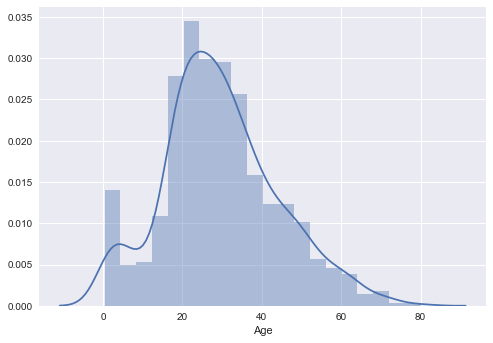

In [6]:
import seaborn as sns
sns.distplot(df_train['Age'].dropna())
sns.plt.show()

In [8]:
from sklearn.preprocessing import Imputer
imp_age = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_age = imp_age.fit_transform(df_train['Age'].values.reshape(-1,1))

In [9]:
port_mapping = {label:idx for idx, label in enumerate(np.unique(df_train['Embarked']))}
df_train['portlabel'] = df_train['Embarked'].map(port_mapping)

C:\Users\DSHH\Anaconda2\lib\site-packages\numpy\lib\arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


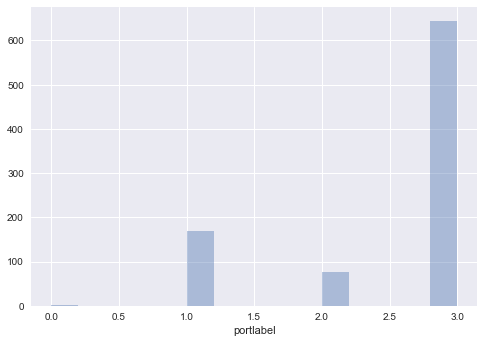

In [10]:
sns.distplot(a=df_train['portlabel'],hist=True,kde=False,rug=False)
sns.plt.show()

In [11]:
df_train['Age'] = imp_age
df_train['Embarked'][df_train['Embarked'].isnull() == True] = 'S'

C:\Users\DSHH\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Embarked       0
portlabel      0
dtype: int64

In [13]:
df_train = df_train.drop('portlabel',axis=1)
df = pd.get_dummies(df_train, columns = ['Pclass','Sex','Embarked'],drop_first=True)

### Modeling

In order to solve this classification problem, I intend to use the following algorithms and see which one gives the best results:
- Logistic Regression
- Decision Tree
- Random Forest (because ensemble method usually gives better results)

In [33]:
X = df.drop(['Survived'],axis=1)
y = df['Survived']

In [34]:
X.head(5)

,PassengerId,Age,SibSp,Parch,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,1,22.0,1,0,0,1,1,0,1
1,2,38.0,1,0,0,0,0,0,0
2,3,26.0,0,0,0,1,0,0,1
3,4,35.0,1,0,0,0,0,0,1
4,5,35.0,0,0,0,1,1,0,1


In [35]:
y.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [60]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,accuracy_score

Split on the train data because I want to leave a validation dataset, it will be 10% of the train data.

In [37]:
np.random.seed(323212)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 42)

#### 1. Logistic Regression

In [39]:
logreg = LogisticRegression()
c_space = np.logspace(-5,8,50)
param_grid = {'penalty':['l1','l2'],'C':c_space}
logreg_cv = RandomizedSearchCV(logreg,param_grid,cv=5)
logreg_cv.fit(X_train,y_train)
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'penalty': 'l2', 'C': 0.32374575428176466}
Tuned Logistic Regression Accuracy: 0.796504369538


In [47]:
y_pred = logreg_cv.predict(X_test)
accuracy_score(y_test,y_pred)

0.83333333333333337

#### 2. Decision Tree

In [53]:
tree = DecisionTreeClassifier()
param_dist = {"max_depth": np.arange(1,9,1),
              "max_features": np.arange(1,9,1),
              "min_samples_leaf": np.arange(1,9,1),
              "criterion": ["gini", "entropy"]}
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_cv.fit(X_train,y_train)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_features': 8, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2}
Best score is 0.80024968789


In [54]:
y_pred_tree = tree_cv.predict(X_test)
accuracy_score(y_test,y_pred_tree)

0.83333333333333337

#### 3. Random Forest

In [73]:
rf = RandomForestClassifier()
param_rf = {'n_estimators':np.arange(100,1000,100),
           'criterion':['gini','entropy'],
           'max_depth':np.arange(1,20,1)}
rf_cv = RandomizedSearchCV(rf,param_rf,cv=5)
rf_fit = rf_cv.fit(X_train,y_train)
print("Tuned Decision Tree Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))

Tuned Decision Tree Parameters: {'n_estimators': 700, 'criterion': 'entropy', 'max_depth': 4}
Best score is 0.825218476904


In [74]:
y_pred_rf = rf_cv.predict(X_test)
accuracy_score(y_test,y_pred_rf)

0.82222222222222219

### Test on the testing set

In [75]:
df_test = pd.read_csv('D:/Grad Study!/Competition/Titanic/test.csv''')

In [76]:
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [87]:
df_test.isnull().sum()

PassengerId    0
Age            0
SibSp          0
Parch          0
Pclass_2       0
Pclass_3       0
Sex_male       0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [78]:
df_test = df_test.drop(cols,axis=1)

In [81]:
imp_age_test = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_age_test = imp_age_test.fit_transform(df_test['Age'].values.reshape(-1,1))

In [86]:
df_test['Age'] = imp_age_test
df_test = pd.get_dummies(df_test, columns = ['Pclass','Sex','Embarked'],drop_first=True)

In [88]:
df_test.head(5)

,PassengerId,Age,SibSp,Parch,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,892,34.5,0,0,0,1,1,1,0
1,893,47.0,1,0,0,1,0,0,1
2,894,62.0,0,0,1,0,1,1,0
3,895,27.0,0,0,0,1,1,0,1
4,896,22.0,1,1,0,1,0,0,1


In [94]:
prediction = rf_cv.predict(df_test)

In [95]:
Submission = pd.DataFrame({ 'PassengerId': df_test['PassengerId'],
                            'Survived': prediction })
Submission.to_csv("Submission.csv", index=False)